<a href="https://colab.research.google.com/github/ishandahal/Fun_Projects/blob/master/Classifier_of_Human_robot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Image Classifier
####Given an image of human and a robot, the model attempts to guess the label correctly.

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 1.0MB 6.1MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 358kB 24.0MB/s 
     |████████████████████████████████| 40kB 6.8MB/s 
     |████████████████████████████████| 92kB 11.0MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 2.7MB 16.1MB/s 
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
·········

In [2]:
from fastbook import *
from fastai.vision.widgets import *

###Gathering data 
Downloading images from bing search

In [3]:
key = '294279c4d2b247c1a2d982badbba63d8'

In [4]:
labels = 'human', 'robot'
path = Path('global')

In [5]:
##Making directory for individual labels and storing the images
if not path.exists():
    path.mkdir()
    for label in labels:
        dest = (path/label)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{label}')
        download_images(dest, urls=results.attrgot('content_url'))

In [6]:
#Getting the images from the folder
fns = get_image_files(path)
fns

(#300) [Path('global/robot/00000091.jpg'),Path('global/robot/00000074.jpg'),Path('global/robot/00000048.jpg'),Path('global/robot/00000006.jpg'),Path('global/robot/00000114.jpg'),Path('global/robot/00000043.jpg'),Path('global/robot/00000062.jpg'),Path('global/robot/00000144.jpg'),Path('global/robot/00000122.jpg'),Path('global/robot/00000140.jpg')...]

In [7]:
# Verifying that the links are not broken
failed = verify_images(fns)
failed

(#1) [Path('global/human/00000002.jpg')]

In [8]:
# We found two images that are not going to work for our task 
# We will remove those images
failed.map(Path.unlink);

In [9]:
images = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [10]:
dls = images.dataloaders(path)

In [28]:
##Default augmentations applied to the batch
images = images.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = images.dataloaders(path)

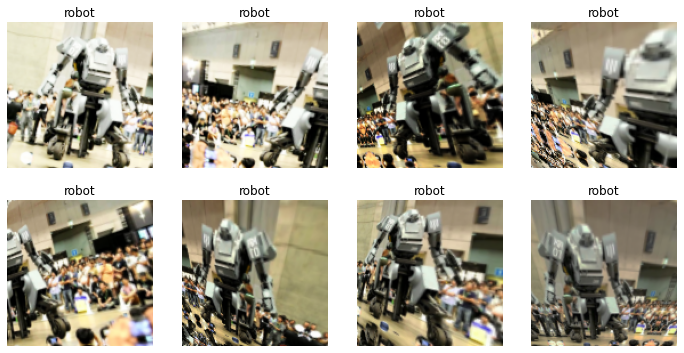

In [27]:
###Checking the transformations and resizes
dls.train.show_batch(max_n=8, nrows=2, unique=True)

###Traing the classifier
Using pretrained network (ResNet18)
Usig error rate as a metric.
Fine tuning the model's parameters for 4 epochs

In [29]:
images = images.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = images.dataloaders(path)

In [30]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.886470,0.433747,0.169492,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.468843,0.259281,0.118644,00:06
1,0.391973,0.199758,0.067797,00:06
2,0.340552,0.189996,0.067797,00:06
3,0.311654,0.162695,0.067797,00:06


###Error rate is about 7%.
Let's look at a confusion matrix for some numbers

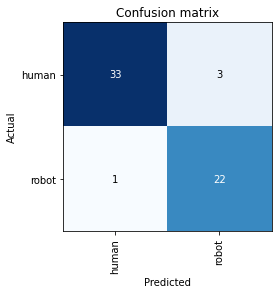

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Our model misclassified 4 images.
Now lets look at some of the misclassified images.

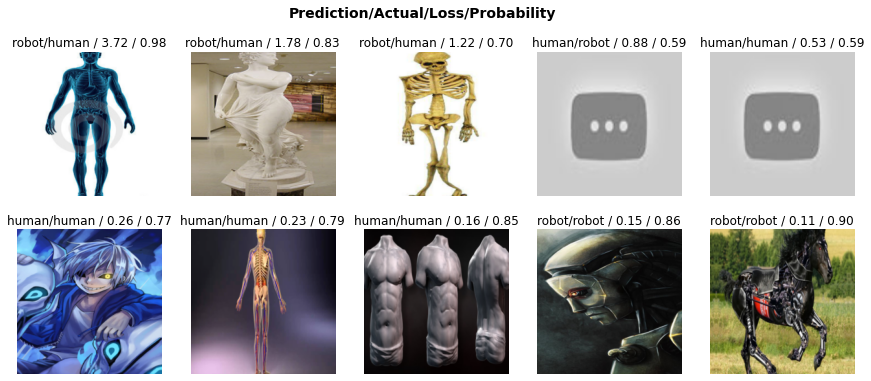

In [33]:
interp.plot_top_losses(10, nrows=2)

We can see that we are not working with the best of datasets. 

In [41]:
learn.predict('/content/example-image.png')

('human', tensor(0), tensor([9.9977e-01, 2.3205e-04]))

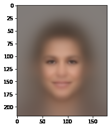

In [42]:
im = '/content/example-image.png'
im = Image.open(im)
im.to_thumb(128, 128)

##The model was able to correctly able to identify the face as human. This image was not part of the dataset. 